# ***AMATRICE-VISSO-NORCIA 2016-2017*** seismic sequence (Central Appennines)

#### The aim is to ***create a seismic catalog using new artificial intelligence methods***, particularly ***PhaseNet*** (Zhu et al., 2019) and the ***Seisbench*** platform, which contains training datasets and other deep learning models for picking.

##### Let's start with the second task:
##### Picks P- and S- wave arrival times for each stations. To do so, we use the Seisbench Platform and use PhaseNet with the training coming from INSTANCE dataset.


##### The parameters to be specified will be:
##### 1. Directory of the experiment;
##### 2. Time interval;
##### 3. Pretrained model used.

In [1]:
#import libraries
import os
import glob
import numpy as np
from obspy import read, Stream
from seisbench.models import PhaseNet
from seisbench.util import stream_to_array
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import pandas as pd

In [2]:
#upload the DNN model and the pretraing data.
model = PhaseNet.from_pretrained("instance")

In [172]:
# Parametes
base_dir='/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/'
net = '8P'
stat='T1243'
year = 2016
start_day = 304
end_day = 304
# Lunghezza della finestra di analisi in secondi
wlength = 7200
channel='H'
base_path = f"{base_dir}TEST_AMATRICE/waveforms/{year}/{net}/{stat}"
paths = {
    "Z": os.path.join(base_path, f"{channel}HZ.D"),
    "N": os.path.join(base_path, f"{channel}HN.D"),
    "E": os.path.join(base_path, f"{channel}HE.D"),
}

In [173]:
print (paths)

{'Z': '/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/8P/T1243/HHZ.D', 'N': '/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/8P/T1243/HHN.D', 'E': '/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/8P/T1243/HHE.D'}


In [174]:
# Read files
def append_component_from_folder(folder, stream, year, start_day, end_day):
    for file in os.listdir(folder):
        if os.path.isfile(os.path.join(folder, file)):
            parts = file.split(".")
            file_year = int(parts[-2])  
            file_day = int(parts[-1])  
            if file_year == year and start_day <= file_day <= end_day:
                single_trace = read(os.path.join(folder, file)) 
                stream.append(single_trace[0]) 

# stream creation
combined_stream = Stream()
for component, path in paths.items():
    append_component_from_folder(path, combined_stream, year, start_day, end_day)

print("Stream combinato:")
print(combined_stream)

Stream combinato:
3 Trace(s) in Stream:
8P.T1243..HHZ | 2016-10-30T00:00:00.000000Z - 2016-10-30T04:17:22.330000Z | 100.0 Hz, 1544234 samples
8P.T1243..HHN | 2016-10-30T00:00:00.000200Z - 2016-10-30T04:17:25.690200Z | 100.0 Hz, 1544570 samples
8P.T1243..HHE | 2016-10-30T00:00:00.000000Z - 2016-10-30T04:17:23.600000Z | 100.0 Hz, 1544361 samples


In [175]:
#print(combined_stream.__str__(extended=True))

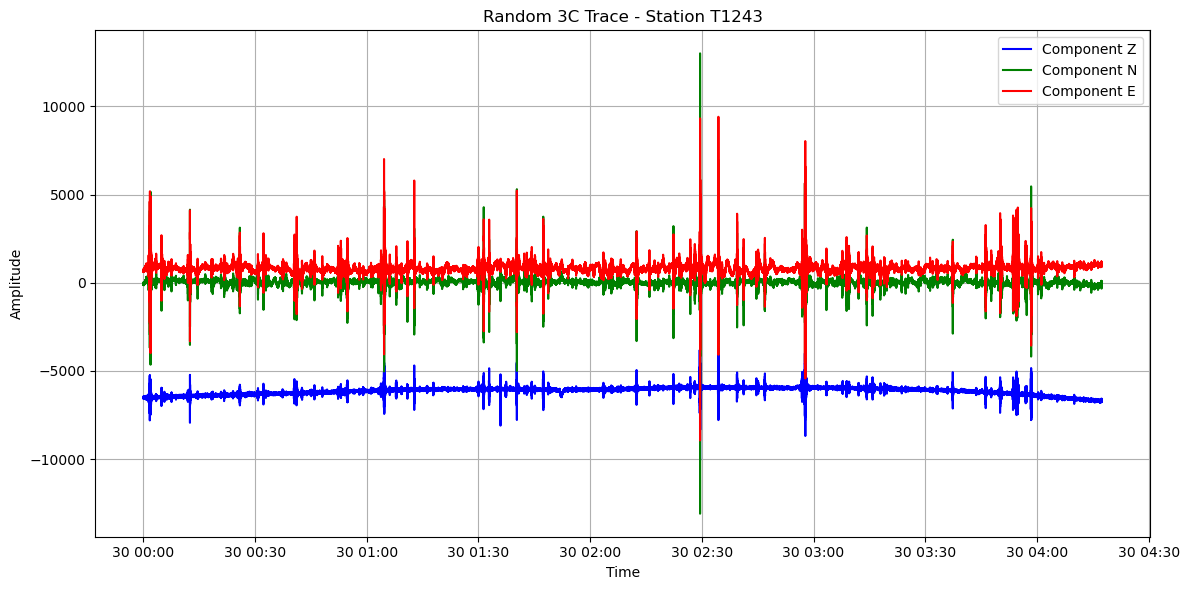

Plot salvato in: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/plot/random_trace_T1243.pdf


In [176]:
import random
import matplotlib.pyplot as plt
from obspy import UTCDateTime

# Random selection
num_traces = len(combined_stream) // 3  # Ogni stazione ha 3 componenti
random_index = random.randint(0, num_traces - 1)
selected_traces = combined_stream[random_index * 3: (random_index + 1) * 3]

# Verify the presence of 3 components
if len(selected_traces) != 3:
    raise ValueError("Le tracce selezionate non contengono esattamente 3 componenti.")

# color for components
color_map = {"Z": "blue", "N": "green", "E": "red"}
label_map = {"Z": "Component Z", "N": "Component N", "E": "Component E"}

# station name selection
stat = selected_traces[0].stats.station

# begin plot
plt.figure(figsize=(12, 6))

# plot each component
for tr in selected_traces:
    component = tr.stats.channel[-1]  # Assume che il canale termini con Z, N o E
    time_axis = [UTCDateTime(t).datetime for t in tr.times("timestamp")]
    plt.plot(time_axis, tr.data, color=color_map.get(component, "black"), label=label_map.get(component, f"Component {component}"))

# plot configuratin
plt.title(f"Random 3C Trace - Station {stat}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()

output_folder = "/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/plot"
os.makedirs(output_folder, exist_ok=True)  # Crea la cartella se non esiste

# save plot
output_path = os.path.join(output_folder, f"random_trace_{stat}.pdf")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot salvato in: {output_path}")

In [177]:
#DEBUG duplicate trace
unique_traces = {}
for trace in combined_stream:
    key = (
        trace.stats.network,
        trace.stats.station,
        trace.stats.channel,
        int(trace.stats.starttime.timestamp),
        int(trace.stats.endtime.timestamp)
    )
    if key not in unique_traces:
        unique_traces[key] = trace

# New stream withoud duplicates
combined_stream = Stream(traces=list(unique_traces.values()))
print(f"Stream checked with {len(combined_stream)} unique traces.")

Stream checked with 3 unique traces.


In [178]:
# First run of prediction using annotate function on seisbench
annotations = model.annotate(combined_stream)
print("\nAnnotations (time arrival):")
for i, annotation in enumerate(annotations):
    print(f"Annotation {i+1}: {annotation}")


Annotations (time arrival):
Annotation 1: 8P.T1243..PhaseNet_P | 2016-10-30T00:00:02.500000Z - 2016-10-30T04:17:23.190000Z | 100.0 Hz, 1544070 samples
Annotation 2: 8P.T1243..PhaseNet_S | 2016-10-30T00:00:02.500000Z - 2016-10-30T04:17:23.190000Z | 100.0 Hz, 1544070 samples
Annotation 3: 8P.T1243..PhaseNet_N | 2016-10-30T00:00:02.500000Z - 2016-10-30T04:17:23.190000Z | 100.0 Hz, 1544070 samples


In [179]:
# convert annotations into discrete arrival times and define the picking probability
outputs = model.classify(combined_stream, batch_size=256, P_threshold=0.5, S_threshold=0.5).picks
Counter([p.phase for p in outputs])
Counter([s.phase for s in outputs])

Counter({'P': 189, 'S': 130})

In [180]:
# Print the picks
print("\nPredizioni di classificazione:")
for i, prediction in enumerate(outputs):
    print(f"Predictions {i+1}: {prediction}")


Predizioni di classificazione:
Predictions 1: 8P.T1243.	2016-10-30T00:01:37.520000Z	P
Predictions 2: 8P.T1243.	2016-10-30T00:03:25.450000Z	P
Predictions 3: 8P.T1243.	2016-10-30T00:04:47.320000Z	P
Predictions 4: 8P.T1243.	2016-10-30T00:04:52.340000Z	S
Predictions 5: 8P.T1243.	2016-10-30T00:06:13.370000Z	P
Predictions 6: 8P.T1243.	2016-10-30T00:06:45.010000Z	S
Predictions 7: 8P.T1243.	2016-10-30T00:07:30.200000Z	P
Predictions 8: 8P.T1243.	2016-10-30T00:07:34.970000Z	S
Predictions 9: 8P.T1243.	2016-10-30T00:08:44.630000Z	P
Predictions 10: 8P.T1243.	2016-10-30T00:08:47.340000Z	S
Predictions 11: 8P.T1243.	2016-10-30T00:09:31.910000Z	P
Predictions 12: 8P.T1243.	2016-10-30T00:10:43.570000Z	P
Predictions 13: 8P.T1243.	2016-10-30T00:11:53.930000Z	P
Predictions 14: 8P.T1243.	2016-10-30T00:11:58.680000Z	S
Predictions 15: 8P.T1243.	2016-10-30T00:12:26.790000Z	P
Predictions 16: 8P.T1243.	2016-10-30T00:12:32.190000Z	S
Predictions 17: 8P.T1243.	2016-10-30T00:13:56.730000Z	P
Predictions 18: 8P.T1243.

In [181]:
#convert the dictonary into a dataframe
#print(outputs.picks[0].__dict__)
pick_df = []
for p in outputs:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)

In [182]:
#Sort picks
pick_df.sort_values("timestamp")

,id,timestamp,prob,type
0,8P.T1243.,2016-10-30 00:01:37.520,0.940328,p
1,8P.T1243.,2016-10-30 00:03:25.450,0.519463,p
2,8P.T1243.,2016-10-30 00:04:47.320,0.960911,p
3,8P.T1243.,2016-10-30 00:04:52.340,0.778238,s
4,8P.T1243.,2016-10-30 00:06:13.370,0.741422,p
...,...,...,...,...
314,8P.T1243.,2016-10-30 04:12:33.420,0.647856,s
315,8P.T1243.,2016-10-30 04:14:27.530,0.856370,p
316,8P.T1243.,2016-10-30 04:14:33.130,0.577906,s
317,8P.T1243.,2016-10-30 04:15:18.760,0.881996,p


In [183]:
#save picking
output_folder_picks = "/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/pick_list"
os.makedirs(output_folder_picks, exist_ok=True)  # Crea la cartella se non esiste

# save plot
pick_path = os.path.join(output_folder_picks, f'picks_{stat}.csv')
pick_df.to_csv(pick_path, index=False)

##### Sort the picking of all stations into a single file!
##### We'll obtain a list of picks sorted by time

###### P.S. Run this cell when you have all the stations' picks.

In [184]:
#define input and output file
file_in=f"{output_folder_picks}/all_picks_2016.dat"
file_out=f"{output_folder_picks}/all_picks_2016_sort.dat"

In [185]:
#function to sort picks
def sort_seismic_picking(input_file, output_file):
    # Caricamento del file con header corretto
    df = pd.read_csv(input_file, sep=",")

    # Conversione della colonna timestamp in datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")

    # Rimozione delle righe con timestamp non validi (se presenti)
    df = df.dropna(subset=["timestamp"])

    # Ordinamento per timestamp
    df_sorted = df.sort_values(by="timestamp")

    # Salvataggio del file ordinato
    df_sorted.to_csv(output_file, index=False)
    print(f"Save file as: {output_file}")

In [186]:
#save file 
sort_seismic_picking(file_in,file_out)

Save file as: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/output/pick_list/all_picks_2016_sort.dat
